TITANIC 02 - Visulization
=========================

24/03/2018

Let's visulize the data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style('white')
sns.set_context("poster")

df = pd.read_csv('./data/train-01-c.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,Title,Fancy_title
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Braund,Mr,False
2,1,1,female,38.0,1,0,71.2833,C,Cumings,Mrs,False
3,1,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss,False
4,1,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs,False
5,0,3,male,35.0,0,0,8.0500,S,Allen,Mr,False


# Basic Visulization

## Sex

In [2]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

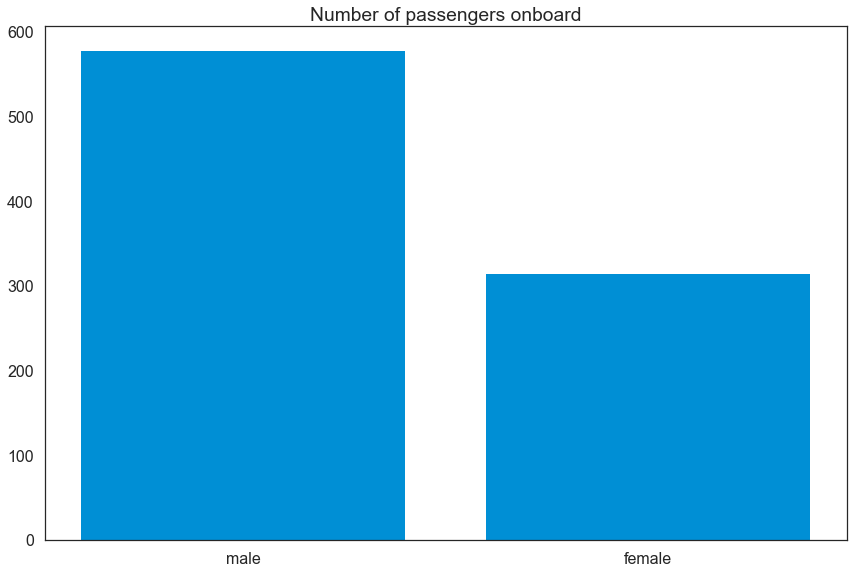

In [3]:
sex_cat = []
sex_num = []
for kpp in df.Sex.value_counts().items():
    sex_cat.append(kpp[0])
    sex_num.append(kpp[1])
ind = np.arange(len(sex_cat))
plt.bar(ind, sex_num)
plt.xticks(ind, sex_cat)
_ = plt.title('Number of passengers onboard')

## Pclass

In [4]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

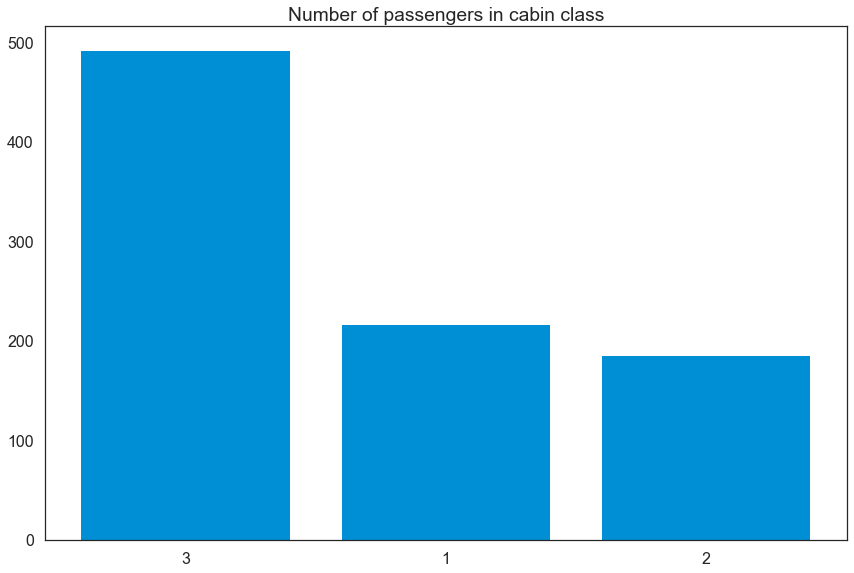

In [5]:
pclass_cat = df.Pclass.value_counts().keys().tolist()
pclass_num = df.Pclass.value_counts().tolist()
ind = np.arange(len(pclass_cat))
plt.bar(ind, pclass_num)
plt.xticks(ind, pclass_cat)
_ = plt.title('Number of passengers in cabin class')

Majority of the visitors are in class 3, about twice as many as class 1 and 2

### What about the gender distribution in different pclasses?

In [6]:
def plot_bar(cat, num, fig_title):
    """
    cat: categories
    num: height of the bar
    fig_title: title of the figure
    """
    ind = np.arange(len(cat))
    plt.bar(ind, num)
    plt.xticks(ind, cat)
    plt.title(fig_title)

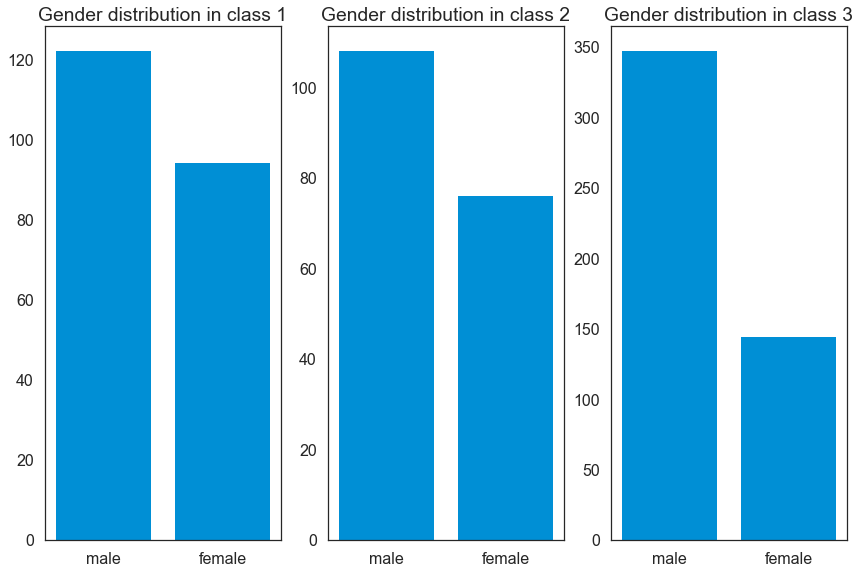

In [7]:
for pclass in pclass_cat:
    dft = df[df['Pclass'] == pclass]
    sex_cat = []
    sex_num = []
    for kpp in dft.Sex.value_counts().items():
        sex_cat.append(kpp[0])
        sex_num.append(kpp[1])
    fig_title = "Gender distribution in class {}".format(pclass)
    plt.subplot(1, 3, pclass)
    _ = plot_bar(sex_cat, sex_num, fig_title)

Class 3 has the largest gap in gender distribution compared to the others. (Theory: rich people in 1911 can afford to bring their wives with them, while majority of working class people are male and cannot afford to bring their wives)

Suprisingly, there are more people in class 1 than class 2

## Fare

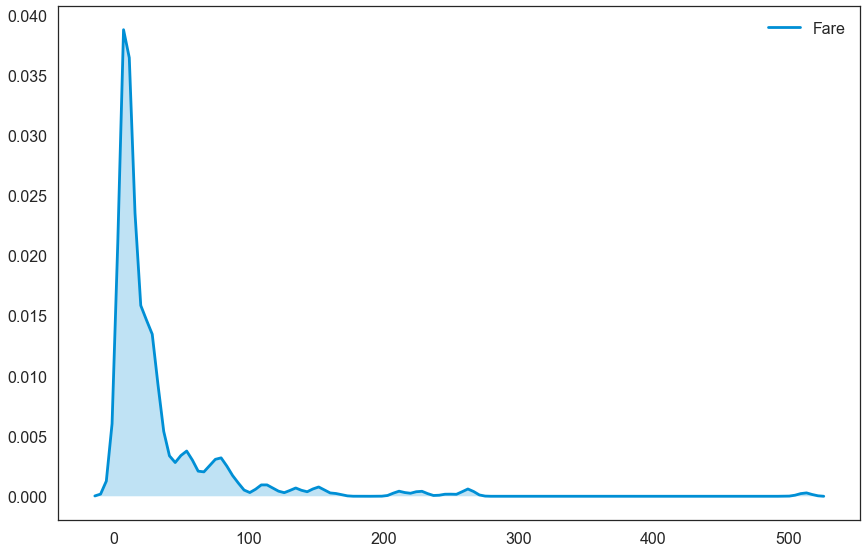

In [8]:
_ = sns.kdeplot(df.Fare, shade=True)

How many people paid nothing to get on the Titanic?

In [9]:
print("Number of people who got free ticket: {}".format((df.Fare == 0).sum()))
print("Most people paid this much: £{:.2f}".format(df.Fare.value_counts().keys()[0]))

Number of people who got free ticket: 15
Most people paid this much: £8.05


In [10]:
df[df.Fare == 0.].Pclass.value_counts()

2    6
1    5
3    4
Name: Pclass, dtype: int64

Seem's like there're about the same amount of people who paid nothing to get onboard passenger classes

## Age

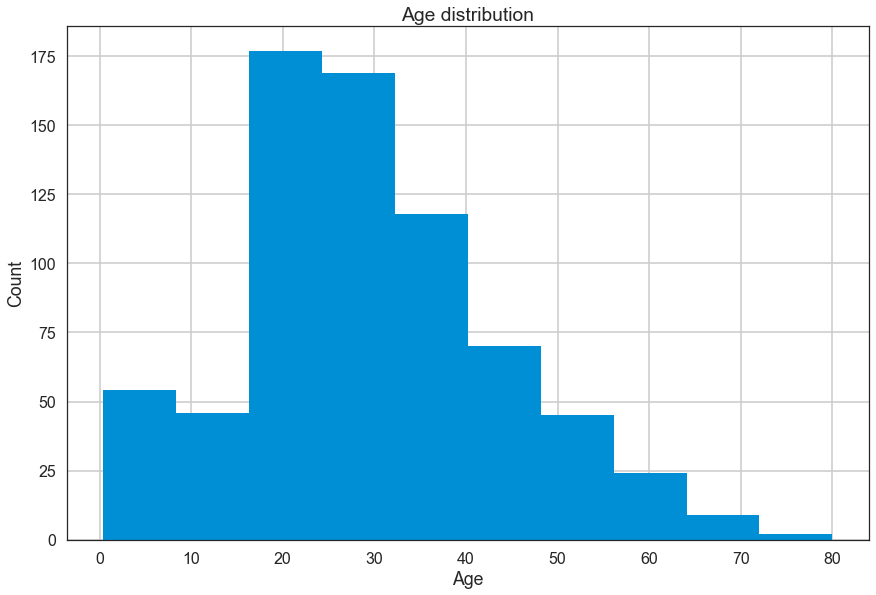

In [11]:
df.Age.hist()
plt.xlabel('Age')
plt.ylabel('Count')
_ = plt.title('Age distribution')

Hypothesis: below a certain age, the tickets are more expensive than other (onboard with parents at better class), then the price goes down (working class), then up again (older generation at better class)

We can "bin" the ages by every 5 years and find the average cost

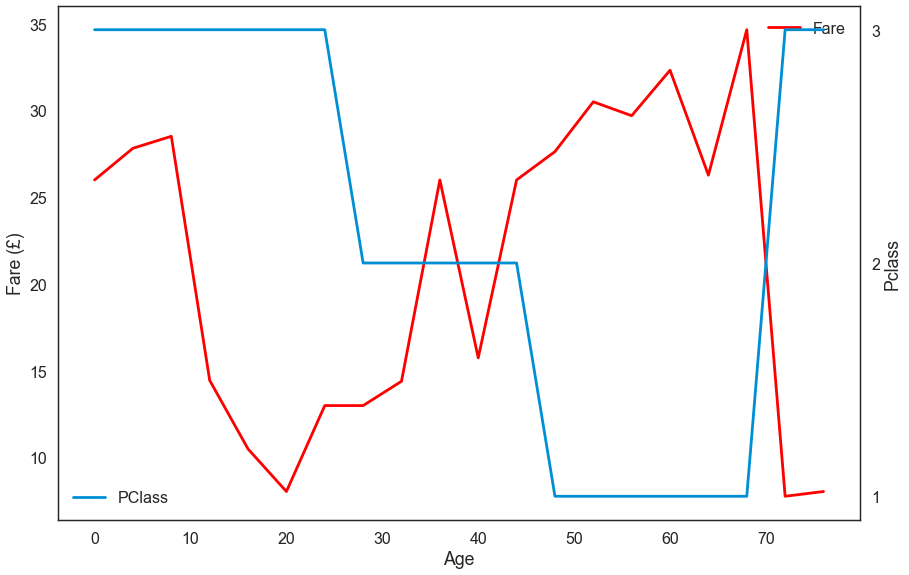

In [12]:
bins = np.arange(int(df.Age.min()), df.Age.max(), 4)
groups = df[['Age', 'Fare', 'Pclass']].groupby(np.digitize(df.Age, bins)).median()

fare = groups.Fare.values
pclass = groups.Pclass.values

fig, ax1 = plt.subplots()

ax1.plot(bins, fare, label='Fare', c='r')
ax1.set_xlabel('Age')
ax1.set_ylabel('Fare (£)')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(bins, pclass, label='PClass')
ax2.set_ylabel('Pclass')
ax2.set_yticks([1,2,3])
_ = ax2.legend()

Seems like young people (age < 10) paid quite a lot to get into class 3 (probably with family), while the same price range can put 55 years old into class 1. There's a significant fare paid drop at age 20 and 70. The sample size for older people is too small maybe not representative.

For age estimation:

* Age < 10: Paid a lot but still in class 3
* 11 to 30: Paid the least
* 30 to 80: Paid quite a lot and in class 1

Using the rules above should be able to estimate the 0 to 30 years old quite nicely, but age 30 to 80 requires another feature to narrow down the possibilities.

## Age and other features

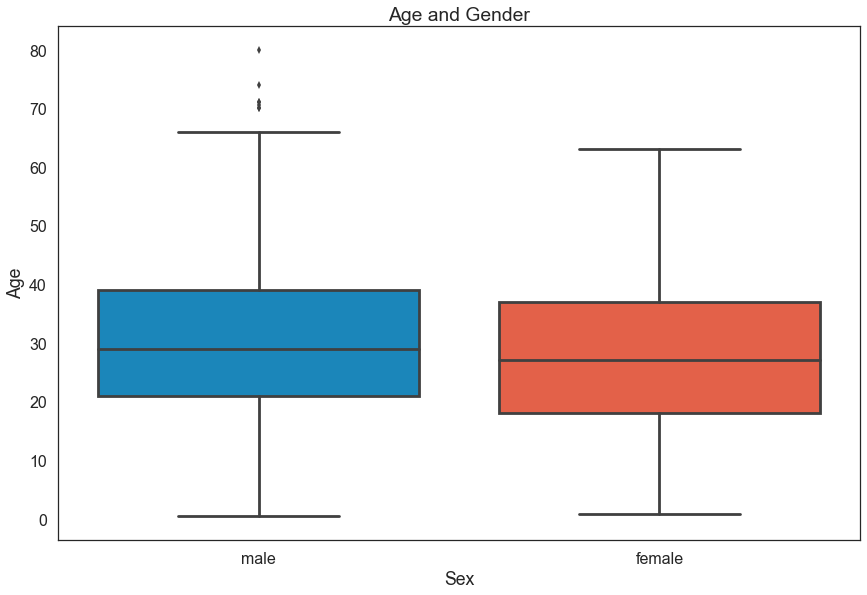

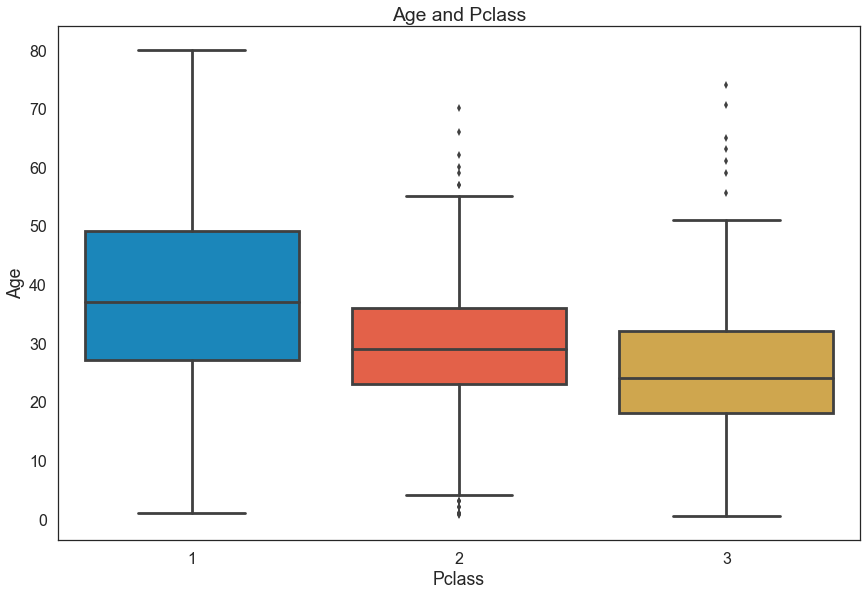

In [13]:
plt.figure()
sns.boxplot(data=df, x='Sex', y='Age')
plt.title('Age and Gender')
plt.figure()
sns.boxplot(data=df, x='Pclass', y='Age')
_ = plt.title('Age and Pclass')

Seems like younger people tend to be in a lower passenger class

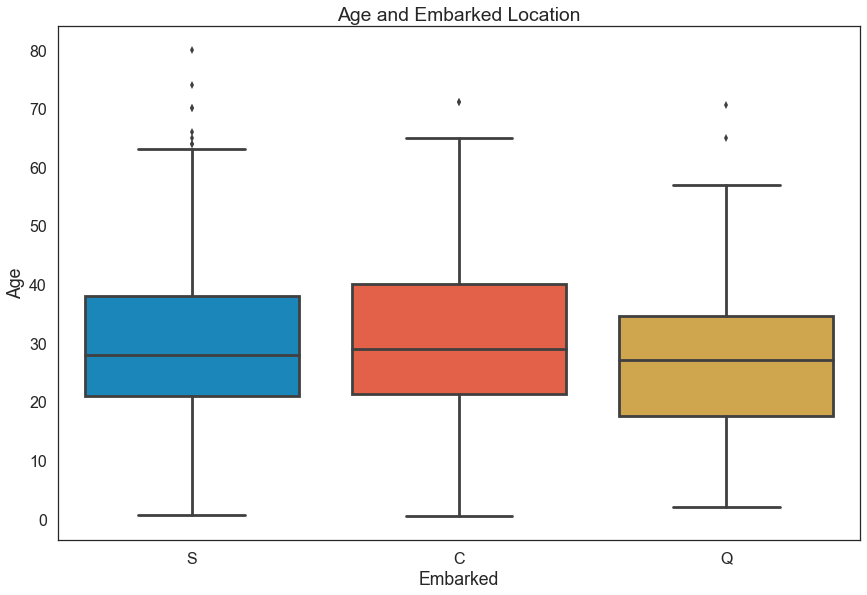

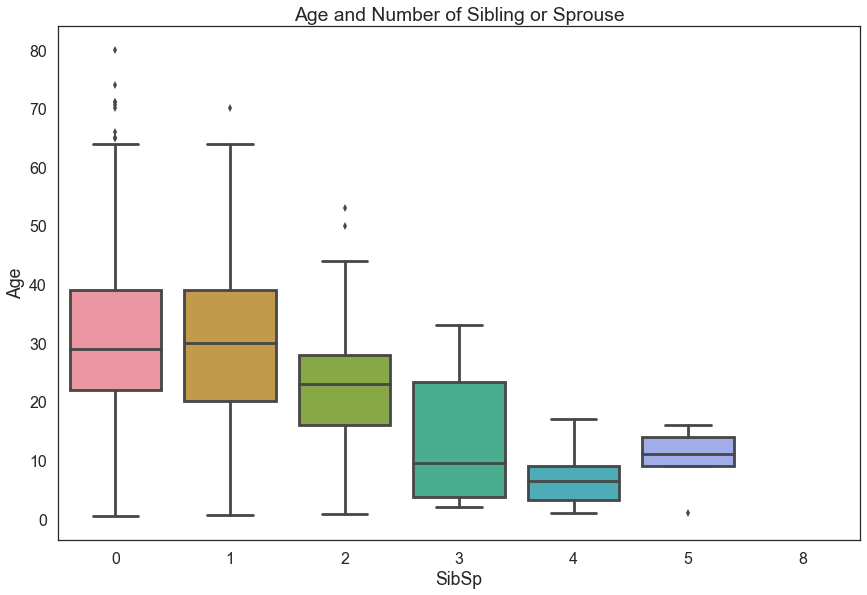

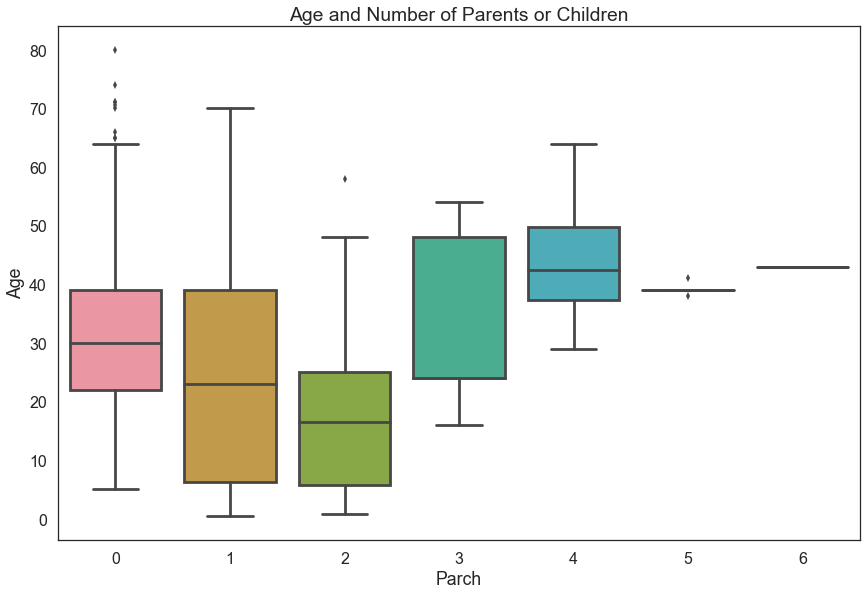

In [14]:
plt.figure()
sns.boxplot(data=df, x='Embarked', y='Age')
plt.title('Age and Embarked Location')
plt.figure()
sns.boxplot(data=df, x='SibSp', y='Age')
plt.title('Age and Number of Sibling or Sprouse')
plt.figure()
sns.boxplot(data=df, x='Parch', y='Age')
plt.title('Age and Number of Parents or Children')

People travelling with many siblings (SibSp> 3) tend to be younger (age < 20).

# Survival

Select features that influences the survival rate of the passenger and drop those that don't

## Age and Gender

In [15]:
suv_male = df[(df['Survived'] == 1) & (df['Sex'] == 'male')].Age
suv_female = df[(df['Survived'] == 1) & (df['Sex'] == 'female')].Age
nsuv_male = df[(df['Survived'] == 0) & (df['Sex'] == 'male')].Age
nsuv_female = df[(df['Survived'] == 0) & (df['Sex'] == 'female')].Age

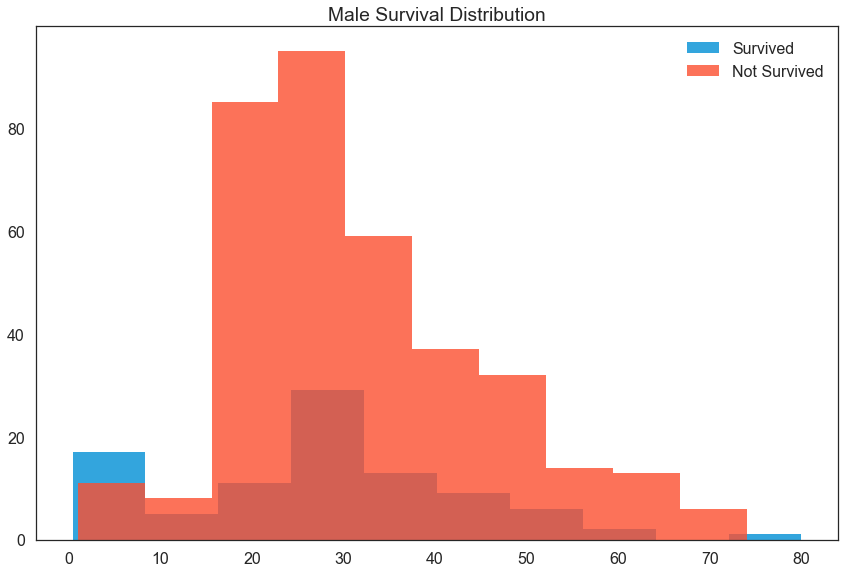

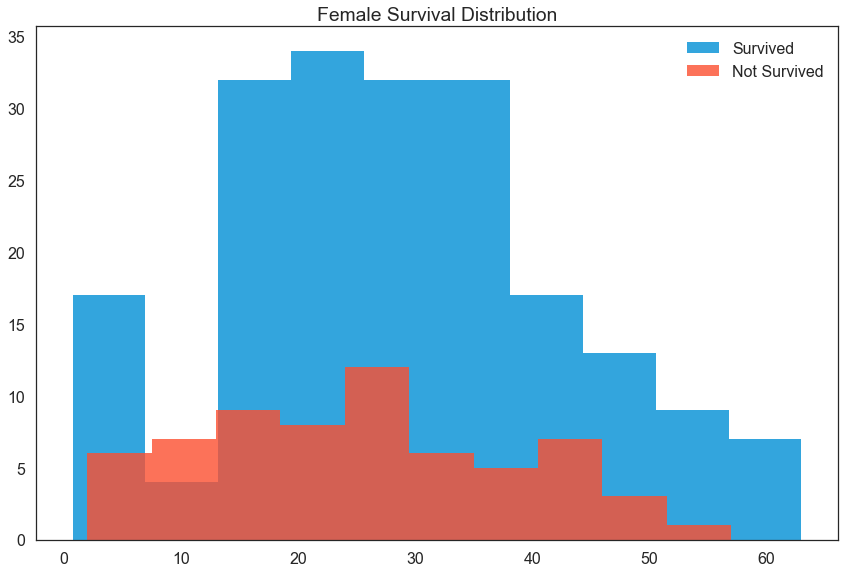

In [16]:
plt.hist(suv_male[~np.isnan(suv_male)], alpha=0.8, label='Survived')
plt.hist(nsuv_male[~np.isnan(nsuv_male)], alpha=0.8, label='Not Survived')
plt.title('Male Survival Distribution')
plt.legend()

plt.figure()
plt.hist(suv_female[~np.isnan(suv_female)], alpha=0.8, label='Survived')
plt.hist(nsuv_female[~np.isnan(nsuv_female)], alpha=0.8, label='Not Survived')
plt.legend()
_ = plt.title('Female Survival Distribution')


There are significantly more male did not survived than those who did, vice versa for female.

Children with Age < 10 has higher survival rate than the others, is there a "feature difference" between the children who survived and who don't?

## SibSp/Parch

In [17]:
df[(df['Age'] < 15) & (df['Survived'] == 0)].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,33.0,33.000000,33.000000,33.000000,33.000000,33.000000
mean,0.0,2.939394,6.984848,3.090909,1.424242,33.403536
std,0.0,0.348155,4.280196,1.568511,0.662868,23.512147
min,0.0,1.000000,1.000000,0.000000,0.000000,7.854200
25%,0.0,3.000000,2.000000,3.000000,1.000000,24.150000
50%,0.0,3.000000,8.000000,4.000000,2.000000,29.125000
75%,0.0,3.000000,10.000000,4.000000,2.000000,39.687500
max,0.0,3.000000,14.500000,5.000000,2.000000,151.550000


In [18]:
df[(df['Age'] < 15) & (df['Survived'] == 1)].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,45.0,45.000000,45.000000,45.000000,45.000000,45.000000
mean,1.0,2.400000,4.959333,0.888889,1.244444,30.458427
std,0.0,0.653661,4.191984,0.934739,0.645106,30.059580
min,1.0,1.000000,0.420000,0.000000,0.000000,7.229200
25%,1.0,2.000000,1.000000,0.000000,1.000000,15.741700
50%,1.0,2.000000,4.000000,1.000000,1.000000,20.575000
75%,1.0,3.000000,7.000000,1.000000,2.000000,31.387500
max,1.0,3.000000,14.000000,4.000000,2.000000,151.550000


The basic summary on age < 15 for those who survived and don't looks quite similar, except for on the `SibSp` column, those who survived are more likely with less sibliings onboard (suppose none of them have a sprouse).

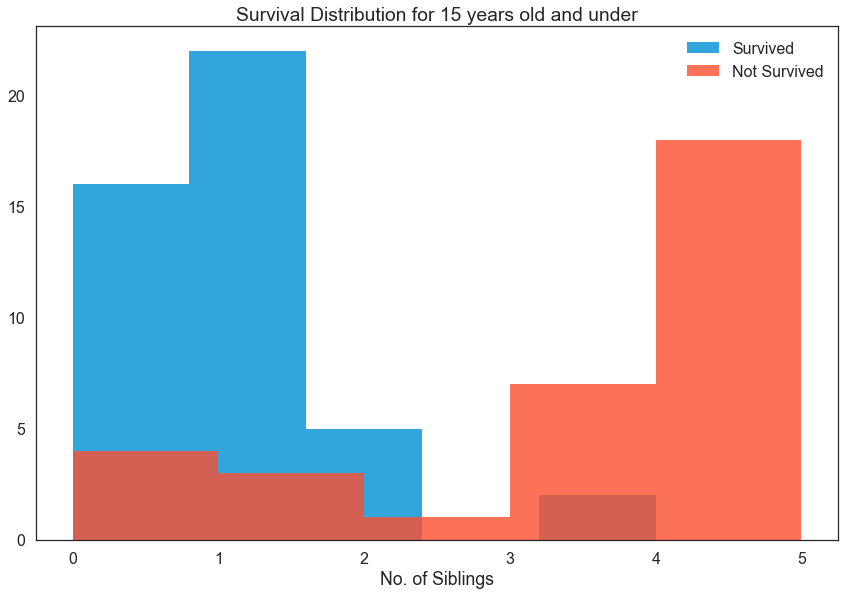

In [19]:
suv_sibsp = df[(df['Age'] < 15) & (df['Survived'] == 1)].SibSp.values
nsuv_sibsp = df[(df['Age'] < 15) & (df['Survived'] == 0)].SibSp.values

plt.hist(suv_sibsp, bins=5, alpha=0.8, label='Survived')
plt.hist(nsuv_sibsp, bins=5, alpha=0.8, label='Not Survived')
plt.legend()
plt.xlabel('No. of Siblings')
_ = plt.title('Survival Distribution for 15 years old and under')

## NEW FEATURE: U15 and Many Siblings

Many siblings defined as the number of siblings > 3 and age < 15

Why is the age threshold at 15? I tried 18 and seems like the figure above becomes less distintive. We can probably do some statistical analysis to determine the threshold but at the moment 15 seems good.

In [20]:
def u15_many_siblings(row):
    if row['Age'] < 15 and row['SibSp'] > 3:
        return True
    else:
        return False
    
df['U15_many_siblings'] = df.apply(u15_many_siblings, axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,Title,Fancy_title,U15_many_siblings
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Braund,Mr,False,False
2,1,1,female,38.0,1,0,71.2833,C,Cumings,Mrs,False,False
3,1,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss,False,False
4,1,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs,False,False
5,0,3,male,35.0,0,0,8.0500,S,Allen,Mr,False,False


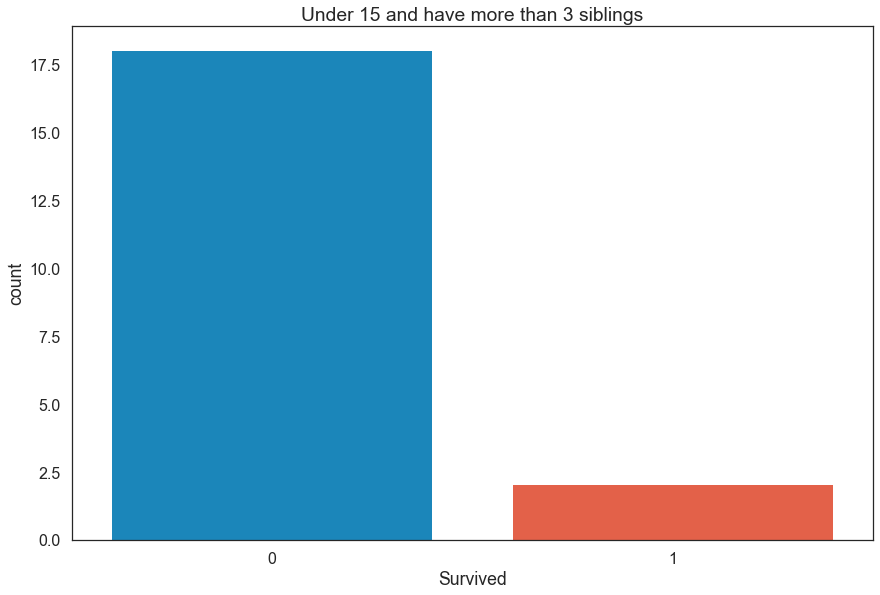

In [21]:
sns.countplot(df[df['U15_many_siblings'] == True].Survived)
_ = plt.title('Under 15 and have more than 3 siblings')

## Family

Does your chance of survival increase if you're on your own?

(Define family as anyone who does not travel alone (ignore mistresses and fiancés))

In [22]:
alone = df[(df['SibSp'] == 0) & (df['Parch'] == 0)].Survived.values
nalone = df[(df['SibSp'] != 0) | (df['Parch'] != 0)].Survived.values

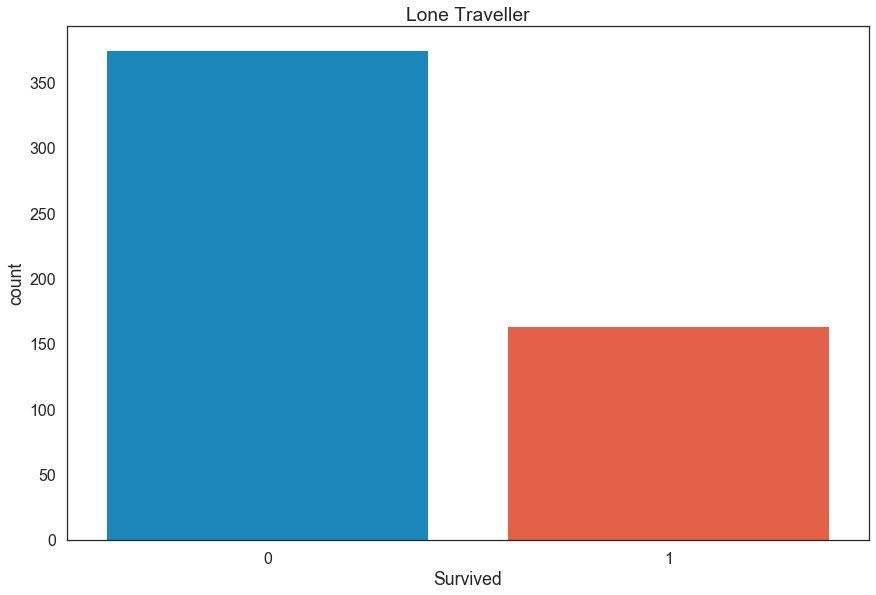

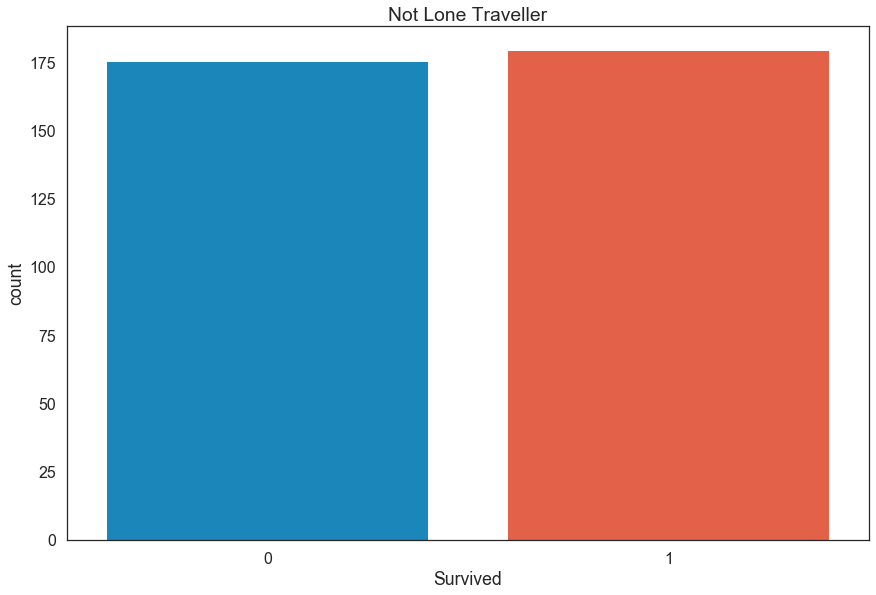

In [23]:
sns.countplot(alone)
plt.xlabel('Survived')
_ = plt.title('Lone Traveller')
plt.figure()
sns.countplot(nalone)
plt.xlabel('Survived')
_ = plt.title('Not Lone Traveller')

Seems quite distinctive

## NEW FEATURE: is_alone

In [24]:
def is_lone_traveller(row):
    if row['SibSp'] == 0 and row['Parch'] == 0:
        return True
    else:
        return False

df['alone'] = df.apply(is_lone_traveller, axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,Title,Fancy_title,U15_many_siblings,alone
PassengerId,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Braund,Mr,False,False,False
2,1,1,female,38.0,1,0,71.2833,C,Cumings,Mrs,False,False,False
3,1,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss,False,False,True
4,1,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs,False,False,False
5,0,3,male,35.0,0,0,8.0500,S,Allen,Mr,False,False,True


## Mothers

If female, are mothers with their children onboard more likely to escape than others?

In [25]:
# Mothers if Mrs and Parch = 1

def is_mother(row):
    if row['Title'] == 'Mrs' and row['Parch'] > 0:
        return True
    else:
        return False

df['is_mother'] = df.apply(is_mother, axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,Title,Fancy_title,U15_many_siblings,alone,is_mother
PassengerId,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Braund,Mr,False,False,False,False
2,1,1,female,38.0,1,0,71.2833,C,Cumings,Mrs,False,False,False,False
3,1,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss,False,False,True,False
4,1,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs,False,False,False,False
5,0,3,male,35.0,0,0,8.0500,S,Allen,Mr,False,False,True,False


In [26]:
suv_mother = df[df['is_mother'] == True].Survived.values
nsuv_mother = df[(df['is_mother'] == False) & (df['Sex'] == 'female')].Survived.values

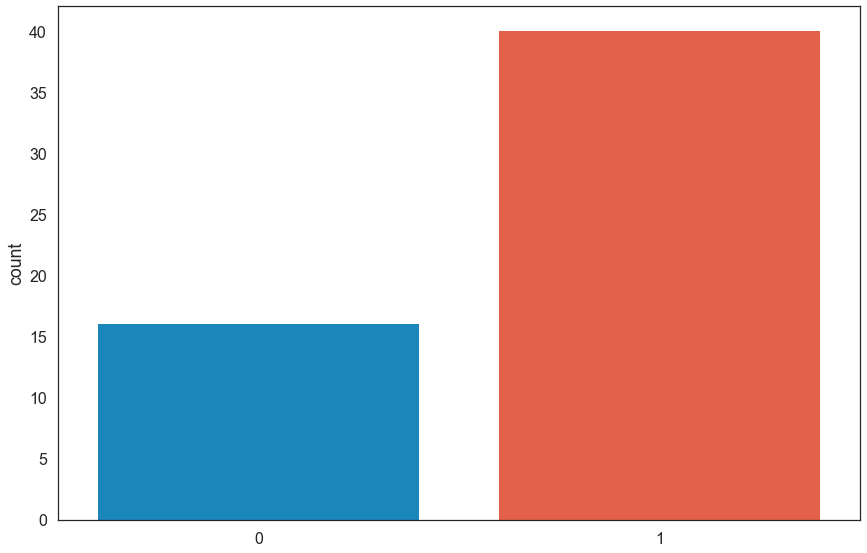

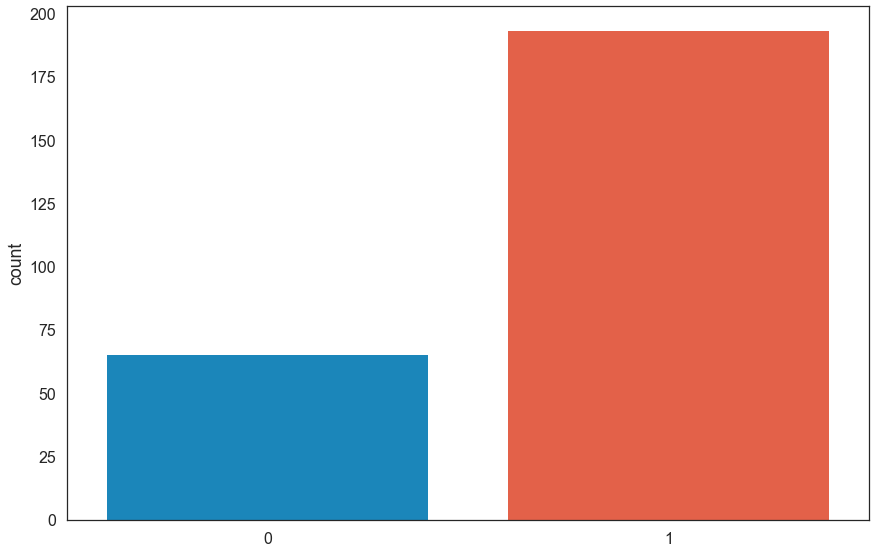

In [27]:
sns.countplot(suv_mother)
plt.figure()
sns.countplot(nsuv_mother)

Not much difference whether you're a mother or not

In [28]:
df = df.drop('is_mother', axis=1)

## Fare

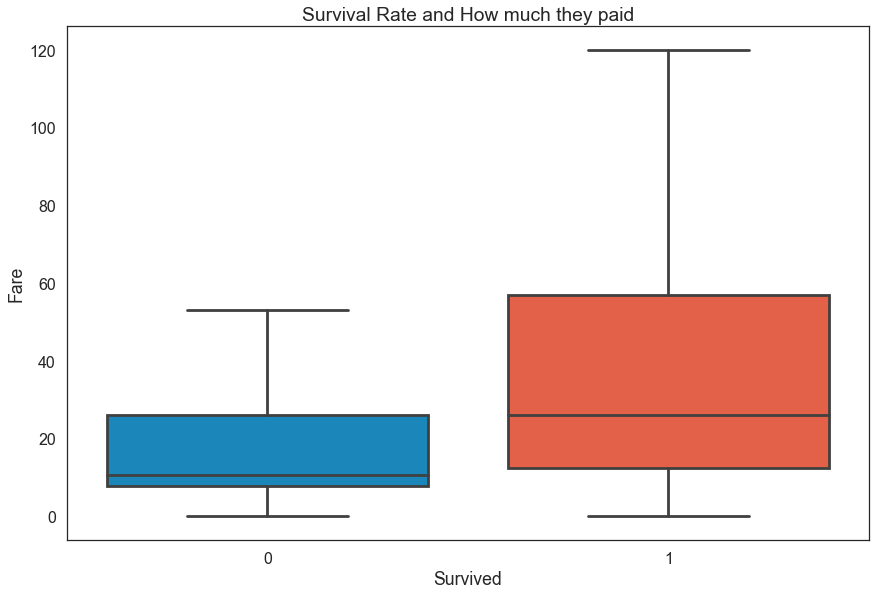

In [29]:
sns.boxplot(data=df, x='Survived', y='Fare', showfliers=False)
_ = plt.title('Survival Rate and How much they paid')

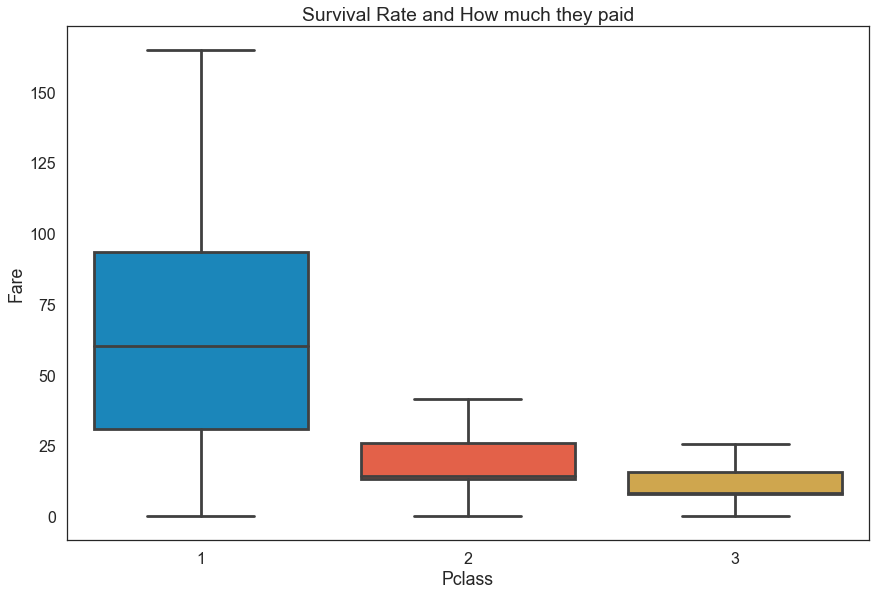

In [30]:
sns.boxplot(data=df, x='Pclass', y='Fare', showfliers=False)
_ = plt.title('Survival Rate and How much they paid')

Seems like people who paid more are more likely to be in a better class, which in turns have a higher survival rate.

## Embarked

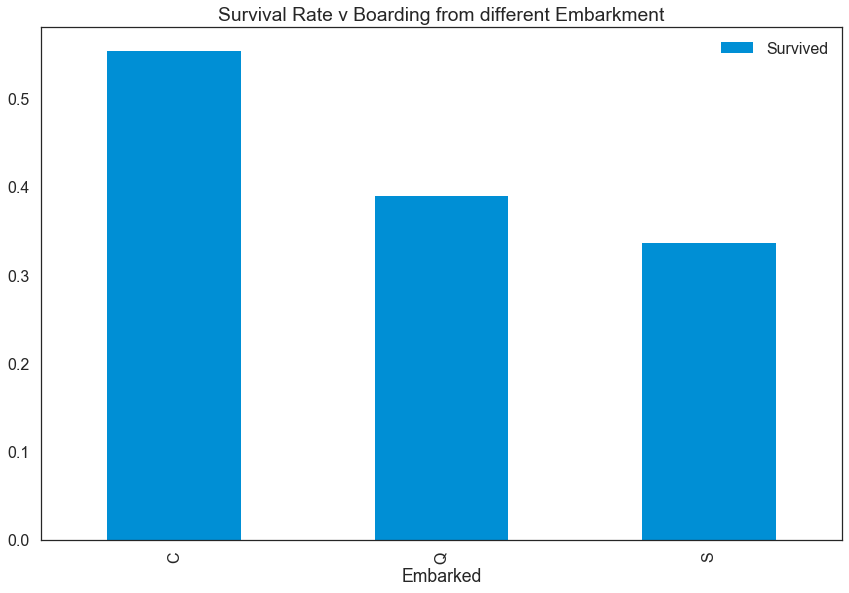

In [31]:
df[['Embarked', 'Survived']].groupby('Embarked').mean().plot(kind='bar')
_ = plt.title('Survival Rate v Boarding from different Embarkment')

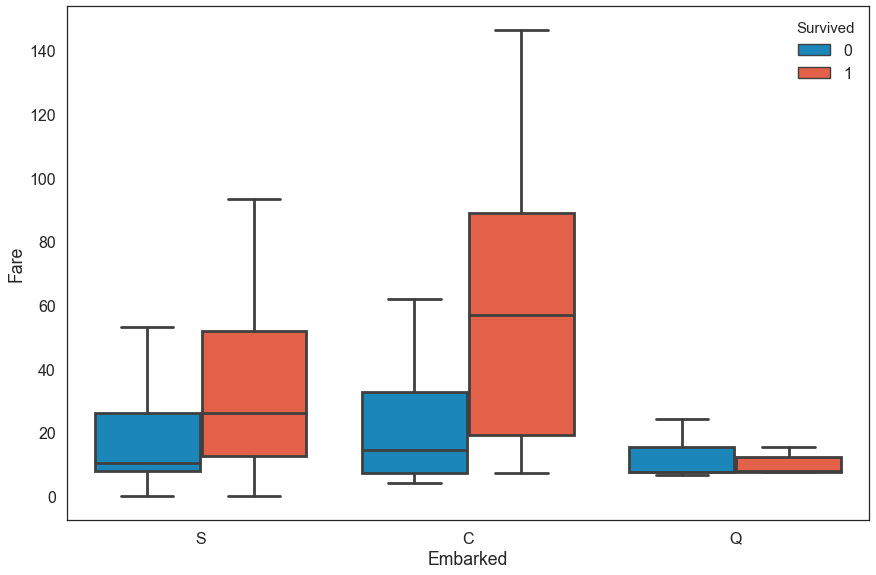

In [32]:
sns.boxplot(x='Embarked', y='Fare', hue='Survived', data=df, showfliers=False)

Seems like people onboard from 'C' has a higher survival rate, especially if the paid more (tend to be in higher pclass).

Save DF

In [33]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,Title,Fancy_title,U15_many_siblings,alone
PassengerId,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Braund,Mr,False,False,False
2,1,1,female,38.0,1,0,71.2833,C,Cumings,Mrs,False,False,False
3,1,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss,False,False,True
4,1,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs,False,False,False
5,0,3,male,35.0,0,0,8.0500,S,Allen,Mr,False,False,True


In [34]:
df.to_csv('./data/train-02-cf.csv')

Next: Feature selection and engineering